In [26]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Microsoft YaHei'  

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
from glob import glob
import pandas as pd
import dask
import dask.dataframe as dd
from dask import delayed
import re
import pandas as pd
import jieba

In [4]:
cluster = SLURMCluster(queue='caslake', cores=20, memory='80GB', 
                       processes=20, walltime='03:00:00', interface='ib0',
                       job_extra_directives=['--account=macs40123']
                      )
cluster.scale(jobs=1)

Task exception was never retrieved
future: <Task finished name='Task-241539' coro=<Client._gather.<locals>.wait() done, defined at /home/yjia2/thesis/thesis/thesis/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/yjia2/thesis/thesis/thesis/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit


In [6]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          38484556   caslake dask-wor    yjia2  R       0:05      1 midway3-0072


In [7]:
client = Client(cluster)
client

<Client: 'tcp://172.25.0.66:35923' processes=20 threads=20, memory=74.60 GiB>

# Data  Clean

In [8]:
xlsx_files = sorted(glob("data/*.xlsx"))
assert xlsx_files, "No .xlsx files found under data/"

In [9]:
def load_excel_fixed(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=0, engine="openpyxl", dtype=str)
    expected_cols = ["年份", "日期", "报纸版次", "标题", "文本内容"]
    missing = [c for c in expected_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{path} : {missing}")
    df = df[expected_cols]
    df["年份"] = pd.to_numeric(df["年份"], errors="raise").astype("Int64")
    for c in ["日期","报纸版次","标题","文本内容"]:
        df[c] = df[c].astype(str)
    df["年份"] = pd.to_numeric(df["年份"], errors="coerce")
    df = df.dropna(subset=expected_cols)
    return df

In [11]:
delayed_parts = [delayed(load_excel_fixed)(p) for p in xlsx_files]

meta = pd.DataFrame({
    "年份": pd.Series(dtype="Int64"),
    "日期": pd.Series(dtype="object"),
    "报纸版次": pd.Series(dtype="object"),
    "标题": pd.Series(dtype="object"),
    "文本内容": pd.Series(dtype="object"),
})

ddf = dd.from_delayed(delayed_parts, meta=meta)

out_dir = "merged_parquet"
ddf.to_parquet(
    out_dir,
    engine="pyarrow",
    write_index=False,
    partition_on=["年份"]
)

print("✅ Merged and partitioned Parquet written to:", out_dir)

✅ Merged and partitioned Parquet written to: merged_parquet


In [ ]:
ddf_check = dd.read_parquet("merged_parquet")
print(ddf_check.npartitions)  
print(ddf_check.head())


78
           日期 报纸版次           标题  \
0  1947-01-01  第4版     我军炮兵大显神威   
1  1947-01-01  第2版      中央局边府军区   
2  1947-01-01  第4版   山东军区一年自卫作战   
3  1947-01-01  第4版      不投降就消灭它   
4  1947-01-01  第3版  新年试谈副刊和群众结合   

                                                文本内容    年份  
0   我军炮兵大显神威 配合步兵迅速解决战斗 刘竞 1947-01-01 第4版() 专栏： 我...  1947  
1   中央局边府军区 新年慰贺民主建国军西北民主联军全体将士 1947-01-01 第2版() ...  1947  
2   山东军区一年自卫作战 共歼蒋军十二万余 今日为山东解放军建军九周年纪念日 1947-01-...  1947  
3   不投降就消灭它！ 蒋军九十六师师部被歼经过 萧里 1947-01-01 第4版() 专栏：...  1947  
4   新年试谈副刊和群众结合 林曦 1947-01-01 第3版() 专栏： 新年试谈副刊和群众...  1947  


In [ ]:
MARK_PATTERNS = [
    r"数据由“马 克 团 队”整理",
    r"来源：百度搜索“马克数据网”",
    r"（更多数据，详见马克数据网）",
    r"详见官网",
    r"来自马克数据网",
    r"该数据由【马克数据网】整理",
    r"关注公众号“马克数据网”",
    r"更多数据：搜索“马克数据网”",
    r"（来自 马克数据网）",
    r"马克数据网"
]

RE_PUNCT = re.compile(r"[，。！？、；：“”‘’（）《》〈〉【】『』「」—…·,.!?;:\"'()\-]+")
RE_BRACKET = re.compile(r"【[^】]*】")

with open("baidu_stopwords.txt", "r", encoding="utf-8") as f:
    STOPWORDS = set([line.strip() for line in f if line.strip()])

def clean_and_segment(text: str, year_val) -> str:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)

    text = RE_BRACKET.sub("", text)

    try:
        y = int(year_val)
    except Exception:
        y = None
    if y is not None and y <= 2002:
        text = re.sub(r"^.*?专栏[:：]", "", text)

    for pat in MARK_PATTERNS:
        text = re.sub(pat, "", text)

    text = RE_PUNCT.sub(" ", text)   

    seg_list = jieba.cut(text)
    seg_text = " ".join(seg_list)

    # Delete all non-Chinese characters (including punctuation, numbers, 
    # and English letters)
    seg_text = re.sub(r"[^ \u4e00-\u9fff]", "", seg_text)

    seg_text = re.sub(r"\s+", " ", seg_text).strip()

    tokens = [w for w in seg_text.split() if w not in STOPWORDS]
    seg_text = " ".join(tokens)

    return seg_text


In [ ]:
import dask.dataframe as dd

ddf = dd.read_parquet("merged_parquet")

# Perform word segmentation cleaning in parallel on each partition
ddf = ddf.assign(
    文本内容_清洗 = ddf.map_partitions(
        lambda df: df.apply(
            lambda row: clean_and_segment(row["文本内容"], row["年份"]),
            axis=1
        ),
        meta=("文本内容_清洗", "object")
    )
)

# Write out new Parquet (keeping year partitions)
out_dir = "cleaned_segmented_parquet"
ddf.to_parquet(
    out_dir,
    engine="pyarrow",
    write_index=False,
    partition_on=["年份"]
)
print("✅ Cleaned and segmented text written to:", out_dir)


✅ Cleaned and segmented text written to: cleaned_segmented_parquet


In [ ]:
ddf_cleaned = dd.read_parquet("cleaned_segmented_parquet")

print(ddf_cleaned.head(5))


           日期 报纸版次           标题  \
0  1947-01-01  第4版     我军炮兵大显神威   
1  1947-01-01  第2版      中央局边府军区   
2  1947-01-01  第4版   山东军区一年自卫作战   
3  1947-01-01  第4版      不投降就消灭它   
4  1947-01-01  第3版  新年试谈副刊和群众结合   

                                                文本内容  \
0   我军炮兵大显神威 配合步兵迅速解决战斗 刘竞 1947-01-01 第4版() 专栏： 我...   
1   中央局边府军区 新年慰贺民主建国军西北民主联军全体将士 1947-01-01 第2版() ...   
2   山东军区一年自卫作战 共歼蒋军十二万余 今日为山东解放军建军九周年纪念日 1947-01-...   
3   不投降就消灭它！ 蒋军九十六师师部被歼经过 萧里 1947-01-01 第4版() 专栏：...   
4   新年试谈副刊和群众结合 林曦 1947-01-01 第3版() 专栏： 新年试谈副刊和群众...   

                                             文本内容_清洗    年份  
0  我军 炮兵 大显神威 配合 步兵 解决 刘竞 此次 苏北 大 歼灭战 中 新四军 炮兵 大显...  1947  
1  中央局 边府 军区 新年 慰贺 民主 建国 军 西北 民主 联军 全体 将士 中央局 边区 ...  1947  
2  山东 军区 一年 自卫 作战 共歼 蒋军 十二 万余 今日 山东 解放军 建军 九 周年 纪...  1947  
3  不 投降 消灭 蒋军 九十六 师师 部 被歼 萧里 前线 记者 萧里 报导 人 圩 宿迁 北...  1947  
4  新年 试谈 副刊 群众 林曦 元旦 照例 一篇 新年 献辞 空话 无益 谈谈 都 关系 一个...  1947  


# EDA

In [38]:
ddf_cleaned = dd.read_parquet("cleaned_segmented_parquet")

In [39]:
ddf_cleaned = ddf_cleaned.categorize(columns=["年份"])
ddf_cleaned = ddf_cleaned.assign(年份=ddf_cleaned["年份"].astype("int64"))

ddf_cleaned = ddf_cleaned.rename(columns={
    "日期": "date",
    "报纸版次": "edition",
    "标题": "title",
    "文本内容": "content_raw",
    "文本内容_清洗": "content_cleaned",
    "年份": "year"
})

print("Total rows:", len(ddf_cleaned))
print("Columns:", list(ddf_cleaned.columns))
print(
    "Year range:",
    ddf_cleaned["year"].min().compute(),
    "-",
    ddf_cleaned["year"].max().compute()
)


Total rows: 2024585
Columns: ['date', 'edition', 'title', 'content_raw', 'content_cleaned', 'year']
Year range: 1947.0 - 2024.0


In [40]:
print("\nData types:")
print(ddf_cleaned.dtypes)


Data types:
date               string[pyarrow]
edition            string[pyarrow]
title              string[pyarrow]
content_raw        string[pyarrow]
content_cleaned    string[pyarrow]
year                         int64
dtype: object



Articles per year:
year
1947    10773
1948     8246
1949    18967
1950    20008
1951    13762
dtype: int64


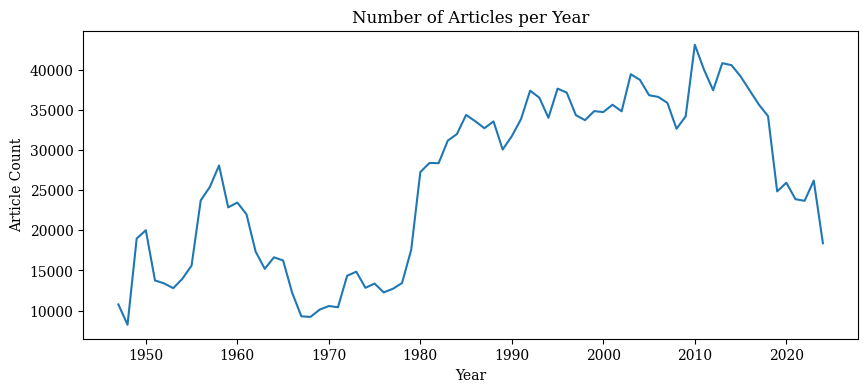

In [ ]:
articles_per_year = ddf_cleaned.groupby("year").size().compute()
print("\nArticles per year:")
print(articles_per_year.head())

# Visualize
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
articles_per_year.plot(kind="line", figsize=(10,4), title=
                       "Number of Articles per Year")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.show()

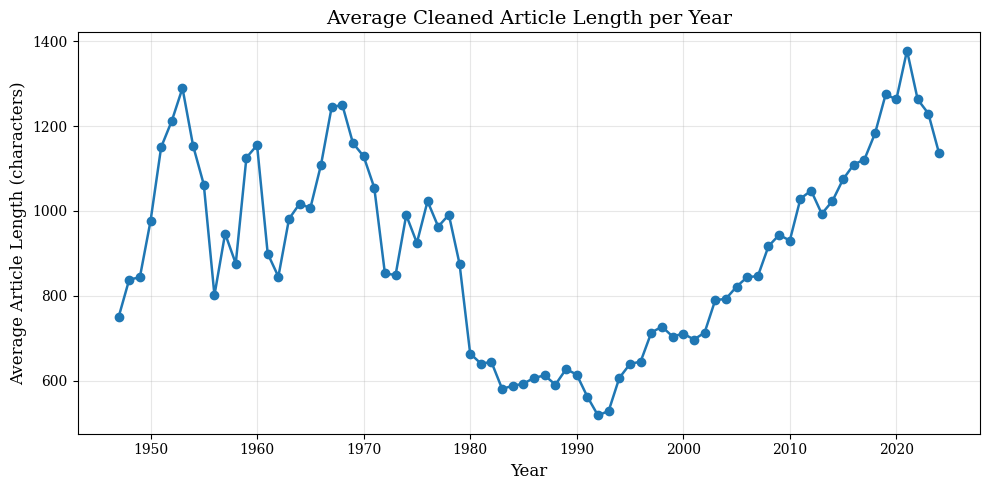

In [ ]:
ddf_cleaned["content_length"] = ddf_cleaned["content_cleaned"].str.len()
ddf_cleaned = ddf_cleaned.persist()
avg_length = (
    ddf_cleaned.groupby("year")["content_length"]
    .mean()
    .compute()
    .sort_index()
)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

# Visualize
plt.figure(figsize=(10,5))
plt.plot(avg_length.index, avg_length.values, marker='o', linewidth=1.8)
plt.title("Average Cleaned Article Length per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Article Length (characters)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Total number of articles containing 'People': 746467


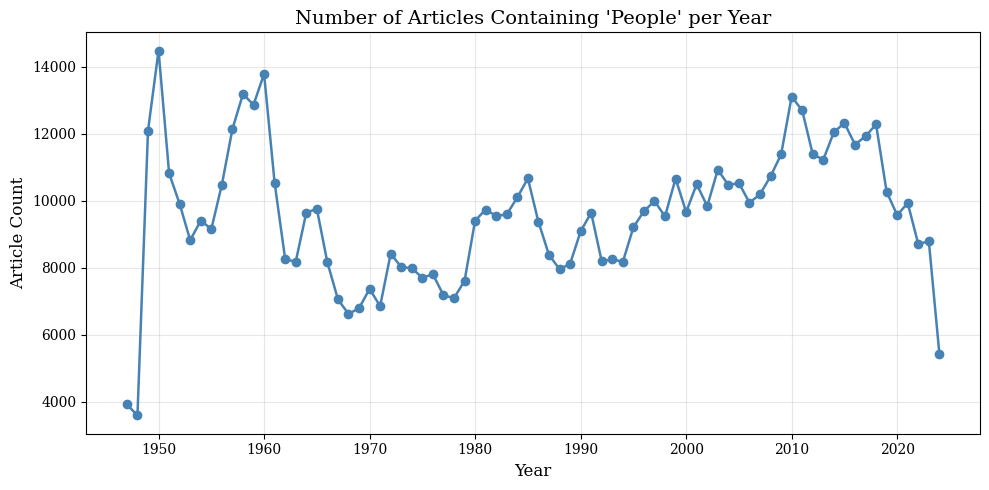

In [ ]:
# Filter articles containing "masses"
mask = ddf_cleaned["content_cleaned"].str.contains("人民", na=False)

# Count the number of articles that appear each year
crowd_per_year = (
    ddf_cleaned[mask]
    .groupby("year")
    .size()
    .compute()
    .sort_index()
)

total_crowd_articles = ddf_cleaned[ddf_cleaned["content_cleaned"].str.contains
                                   ("人民", na=False)].shape[0].compute()
print("Total number of articles containing 'People':", total_crowd_articles)

# Visualize
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 5))
plt.plot(crowd_per_year.index, crowd_per_year.values, marker="o", linewidth=1.8, 
         color="steelblue")
plt.title("Number of Articles Containing 'People' per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Article Count", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
